In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import keras.backend as K

W0426 18:27:41.084827 140233402808128 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
# from datetime import datetime
from tqdm import tqdm_notebook
from itertools import combinations
from scipy.stats import pearsonr

In [3]:
pd.set_option('display.max_colwidth', -1)
rdm_seed = 1
tf.logging.set_verbosity(tf.logging.ERROR)


In [4]:
# df_cloze = pd.read_pickle("../cloze_df_raw2.pickle")
# df_cloze_scores = pd.read_csv("../cloze_df_scores.csv")

# df_cloze['bert_score'] = df_cloze_scores['bert_score']
# df_cloze['glove_score'] = df_cloze_scores['glove_score']

# df_cloze.to_csv("../cloze_df_raw3.csv")
# df_cloze.to_pickle("../cloze_df_raw3.pickle")

# df_cloze = pd.read_pickle("../cloze_df_raw3.pickle")

In [5]:
df_cloze = pd.read_csv("cloze_df_scores_all.csv")

In [6]:
df_cloze["cloze_resp"] = [eval(cloze_resp) for cloze_resp in df_cloze["cloze_resp"]]

In [7]:
df_cloze.head()

,Unnamed: 0,index,cloze_resp,sentID_GM,sentence,targ,targ_POS,cloze_resp_len,ent_elmo,ent_cloze,bert_score,glove_score,Unnamed: 0.1,sent_idx,scores,scores_sum,scores_avg,scores_std,scores_avg_rank
0,0,0,"{'fight': 8, 'rift': 6, 'wall': 2, 'wedge': 1, 'divide': 1, 'disagreement': 1, 'argument': 1, 'resentment': 1, 'chasm': 1, 'battle': 1, 'rivalry': 1, 'grudge': 1, 'third': 1, 'enmity': 1, 'split': 1, 'problem': 1, 'conflict': 1}",{1547},A ______ emerged between the two who were once friends .,{'discord'},NN,[30],2.246163,2.442118,0.724184,0.295388,954,954,"[0, -1, -1, 0, 0, 0, 0, 0, -1, 0, 1, 1, 0, 0, 0, 0, -1, 0, 1, 0, -1, 0, 0, -1]",-3,-0.125000,0.599479,678.5
1,1,1,"{'happy': 6, 'unconventional': 2, 'simple': 2, 'peaceful': 2, 'wild': 2, 'adventurous': 2, 'fun': 2, 'whimsical': 1, 'carefree': 1, 'blast': 1, 'kind': 1, 'nice': 1, 'vibrant': 1, 'adventurer': 1, 'creative': 1, 'witty': 1, 'hipster': 1, 'optimist': 1, 'loving': 1}",{518},A bohemian is a person who is free-spirited and ______ .,{'rakish'},AJ,[30],2.232694,2.765587,0.675923,0.256244,71,71,"[0, 1, 1, 0, 0, 0, 1, 0, 0, -1, -1, 0, -1, 0, -1, 1, 0, 0, 0, 1, 0, -1, 0, 0]",0,0.000000,0.645497,842.0
2,2,2,"{'stole': 13, 'stolen': 7, 'vandalized': 3, 'damaged': 2, 'tore': 1, 'ruined': 1, 'destroyed': 1, 'defaced': 1, 'defiled': 1}",{803},A bunch of kids had broken in and ______ the paintings .,{'defile'},VB,[30],2.243330,1.679603,0.896399,0.525470,694,694,"[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, -1, 0, 0, -1]",-1,-0.041667,0.538452,787.0
3,3,3,"{'berate': 5, 'bully': 4, 'belittle': 3, 'insult': 3, 'push': 2, 'love': 1, 'punish': 1, 'abuse': 1, 'fear': 1, 'badger': 1, 'annoy': 1, 'criticisms': 1, 'dictatorship': 1, 'ridicule': 1, 'scold': 1, 'demoralize': 1, 'order': 1, 'mock': 1}",{747},"A coach should provide leadership, not ______ their players .",{'browbeat'},VB,[30],2.200604,2.682186,0.714305,0.232669,470,470,"[1, 0, 1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0, 0, 1, 0, 0, 1, 0, 0]",6,0.250000,0.595119,1237.5
4,4,4,"{'force': 4, 'get': 3, 'whip': 2, 'bring': 2, 'start': 2, 'prod': 2, 'coach': 1, 'help': 1, 'coerce': 1, 'train': 1, 'lasso': 1, 'hit': 1, 'halt': 1, 'roundup': 1, 'slow': 1, 'coax': 1, 'lead': 1, 'make': 1, 'entice': 1, 'push': 1, 'order': 1}",{875},A cowboy used a short whip to ______ his horse into a slow gallop .,{'goad'},VB,[30],2.221154,2.921658,0.778465,0.250248,1351,1351,"[1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, -1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",8,0.333333,0.552771,1365.5


In [26]:
elmo_mod = hub.Module('https://tfhub.dev/google/elmo/2', trainable=False)

In [27]:
def unMap_list(dictionary):
    """ for bert and glove, compute_sim
    give input:{word1:3,word2:2,...}
        return :[word1,word1,word1,word2,word2 ...]
    """
    un_map_list = []
    for k,v in dictionary.items():
        # v = [freq, embedding]

        for f in range(v):
            un_map_list.append(k)
    return un_map_list

In [43]:
def cloze_resp_vec(elmo_mod, cloze_resp, sent):
    resp_loc = sent.split().index("______")
    sent_w_targ = [sent.replace("______", resp) for resp in cloze_resp.keys()]
    res_vec = elmo_mod(sent_w_targ, as_dict=True, signature='default')['elmo']
    elmo_vec = res_vec[:, resp_loc, :]
#     return(cloze_resp, res_vec[:, resp_loc, :])

# def cloze_resp_sim(cloze_resp, elmo_vec):
# #     _elmo_vec = K.eval(elmo_vec) 
# #     res_cos_sim = 1-pairwise_distances(tt_vec, metric='cosine')
    res_cos_sim = K.eval(tf.matmul(tf.nn.l2_normalize(elmo_vec, axis=1), 
                                   tf.nn.l2_normalize(elmo_vec, axis=1), adjoint_b=True))
    res_cos_sim = pd.DataFrame(res_cos_sim, columns=cloze_resp.keys(), index=cloze_resp.keys())
    return(res_cos_sim)
    
def cloze_resp_den(sim_mtx_df, cloze_resp):
    resp_pairs = [i for i in combinations(unMap_list(dict(cloze_resp)), 2)]
    sim_scores = []
    for resp_pair in resp_pairs:
        sim_scores.append(sim_mtx_df.loc[resp_pair[0], resp_pair[1]])
    return(np.array(sim_scores).mean())
        

In [44]:
def cloze_sem_den(elmo_mod, cloze_resp, sent):
#     _resp, _vec = cloze_resp_vec(elmo_mod, cloze_resp, sent)
#     _sim = cloze_resp_sim(_resp, _vec)
#     res_den = cloze_resp_den(_sim, _resp)
    _sim = cloze_resp_vec(elmo_mod, cloze_resp, sent)
    res_den = cloze_resp_den(_sim, cloze_resp)
    return(res_den)


In [45]:
K.clear_session()
elmo_mod = hub.Module('https://tfhub.dev/google/elmo/2', trainable=False)
[cloze_sem_den(elmo_mod, df_cloze.iloc[1]['cloze_resp'], df_cloze.iloc[1]['sentence']),
 cloze_sem_den(elmo_mod, df_cloze.iloc[2]['cloze_resp'], df_cloze.iloc[2]['sentence']),
 cloze_sem_den(elmo_mod, df_cloze.iloc[4]['cloze_resp'], df_cloze.iloc[4]['sentence'])]

[0.5421325, 0.77802396, 0.66369915]

In [50]:
# TODO: why is it so slow?
K.clear_session()
# with tf.Session() as sess:

temp_res = []
for i in tqdm_notebook(range(df_cloze.shape[0])):
    K.clear_session()
    elmo_mod = hub.Module('https://tfhub.dev/google/elmo/2', trainable=False)

#     if (i%200==0):
#         print(datetime.now())
    temp_res.append(cloze_sem_den(elmo_mod, df_cloze.iloc[i]['cloze_resp'], df_cloze.iloc[i]['sentence']))
df_cloze['elmo_score'] = temp_res


In [51]:
df_cloze.to_pickle("cloze_df_scores_all2.pickle")

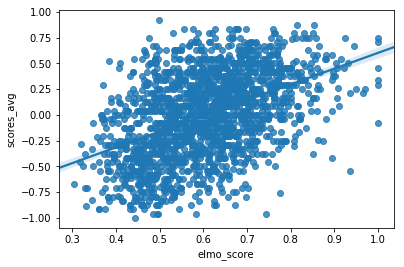

In [53]:
sns.regplot(df_cloze["elmo_score"], df_cloze["scores_avg"])

In [55]:
pearsonr(df_cloze["elmo_score"], df_cloze["scores_avg"])

(0.4544108813431726, 1.4789357274771119e-91)

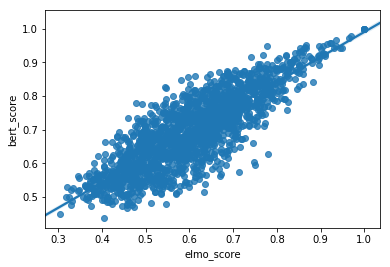

In [56]:
sns.regplot(df_cloze["elmo_score"], df_cloze["bert_score"])

In [57]:
pearsonr(df_cloze["elmo_score"], df_cloze["bert_score"])

(0.8339595788970915, 0.0)

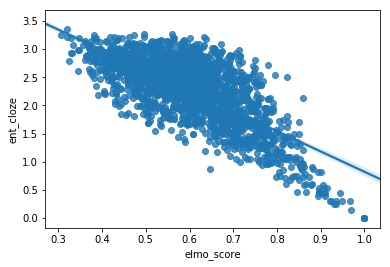

In [58]:
sns.regplot(df_cloze["elmo_score"], df_cloze["ent_cloze"])

In [59]:
pearsonr(df_cloze["elmo_score"], df_cloze["ent_cloze"])

(-0.7261507117825062, 4.344997130634981e-292)